In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [6]:
df = pd.read_csv('train.csv', parse_dates=['Datetime'], index_col='Datetime')
df

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,
2018-01-01 06:20:00+00:00,26.212347,28.696304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.00,3.976499,NaN,NaN,252.00,3.042750
2018-01-01 06:40:00+00:00,59.632658,29.052567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.00,11.091660,NaN,NaN,255.00,3.424814
2018-01-01 06:50:00+00:00,40.889650,28.984758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.75,4.234497,NaN,NaN,264.75,3.507172
2018-01-01 10:40:00+00:00,34.398111,30.282058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.75,5.347792,NaN,NaN,283.75,3.442212
2018-01-01 12:00:00+00:00,29.797653,29.333519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.00,6.022326,NaN,NaN,274.00,3.031363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15 23:10:00+00:00,272.852287,23.500851,43.740629,-0.524250,-0.108540,-0.108540,63.668076,56.801410,1029.697556,64.904780,64.000634,35.012077,35.406250,182.00,54.889963,9.243551,2.0,182.00,5.156629
2020-03-15 23:20:00+00:00,295.675931,23.409183,43.529209,-0.684376,-0.168882,-0.168882,63.361840,56.551527,1032.996150,64.109157,63.189782,35.004216,35.280933,182.00,60.673948,9.269149,2.0,182.00,5.257433
2020-03-15 23:30:00+00:00,295.127333,23.336964,43.331115,-0.743521,-0.292512,-0.292512,63.156279,56.393276,1031.935870,63.740245,62.798514,35.003815,35.140925,182.00,59.551241,9.252811,2.0,182.00,5.188531


In [7]:
df.dropna(inplace=True)

In [8]:
df.columns

Index(['ActivePower', 'AmbientTemperatue', 'BearingShaftTemperature',
       'Blade1PitchAngle', 'Blade2PitchAngle', 'Blade3PitchAngle',
       'GearboxBearingTemperature', 'GearboxOilTemperature', 'GeneratorRPM',
       'GeneratorWinding1Temperature', 'GeneratorWinding2Temperature',
       'HubTemperature', 'MainBoxTemperature', 'NacellePosition',
       'ReactivePower', 'RotorRPM', 'TurbineStatus', 'WindDirection',
       'WindSpeed'],
      dtype='object')

In [9]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

In [10]:
df['lag_1'] = df['ActivePower'].shift(1)
df['lag_hourly'] = df['ActivePower'].shift(6) # hourly lag
df['lag_daily'] = df['ActivePower'].shift(24  * 6) # daily lag
df['lag_monthly'] = df['ActivePower'].shift(24 * 6 * 30) # monthly lag
df

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,...,TurbineStatus,WindDirection,WindSpeed,hour,day_of_week,month,lag_1,lag_hourly,lag_daily,lag_monthly
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-05-06 17:50:00+00:00,474.565555,36.586867,45.918169,2.708014,3.192279,3.192279,61.414332,56.369807,1166.578920,57.880424,...,2.0,261.75,6.065840,17,0,5,NaN,NaN,NaN,NaN
2019-05-06 18:00:00+00:00,589.893812,36.170749,46.489420,-1.008620,-0.493883,-0.493883,66.251776,58.078406,1237.159970,62.280167,...,2.0,246.00,5.952220,18,0,5,474.565555,NaN,NaN,NaN
2019-05-06 18:10:00+00:00,298.980465,35.616976,46.648389,-0.627218,-0.252921,-0.252921,65.805104,58.783376,1046.694640,63.870466,...,2.0,232.50,5.084325,18,0,5,589.893812,NaN,NaN,NaN
2019-05-06 18:20:00+00:00,525.028383,35.549396,46.712733,-1.054078,-0.482359,-0.482359,66.993052,59.313798,1171.735200,65.240211,...,2.0,244.00,6.069695,18,0,5,298.980465,NaN,NaN,NaN
2019-05-06 18:30:00+00:00,672.400830,35.720460,47.198030,-1.149718,-0.562525,-0.562525,69.764490,60.508690,1317.921156,68.392115,...,2.0,249.00,6.742415,18,0,5,525.028383,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-15 23:10:00+00:00,272.852287,23.500851,43.740629,-0.524250,-0.108540,-0.108540,63.668076,56.801410,1029.697556,64.904780,...,2.0,182.00,5.156629,23,6,3,379.026823,306.341284,1708.204650,879.646701
2020-03-15 23:20:00+00:00,295.675931,23.409183,43.529209,-0.684376,-0.168882,-0.168882,63.361840,56.551527,1032.996150,64.109157,...,2.0,182.00,5.257433,23,6,3,272.852287,302.542664,1709.678826,756.529083
2020-03-15 23:30:00+00:00,295.127333,23.336964,43.331115,-0.743521,-0.292512,-0.292512,63.156279,56.393276,1031.935870,63.740245,...,2.0,182.00,5.188531,23,6,3,295.675931,369.686629,1694.993183,793.586247


In [11]:
df['rolling_mean_7_days'] = df['lag_daily'].rolling(window=7*24*6).mean()
df['rolling_mean_30_days'] = df['lag_daily'].rolling(window=30*24*6).mean()
df['rolling_sd_7_days'] = df['lag_daily'].rolling(window=7*24*6).std()
df['rolling_sd_30_days'] = df['lag_daily'].rolling(window=30*24*6).std()
df['rolling_mean_24h'] = df['lag_hourly'].rolling(window=24*6).mean()
df['rolling_sd_24h'] = df['lag_hourly'].rolling(window=24*6).std()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


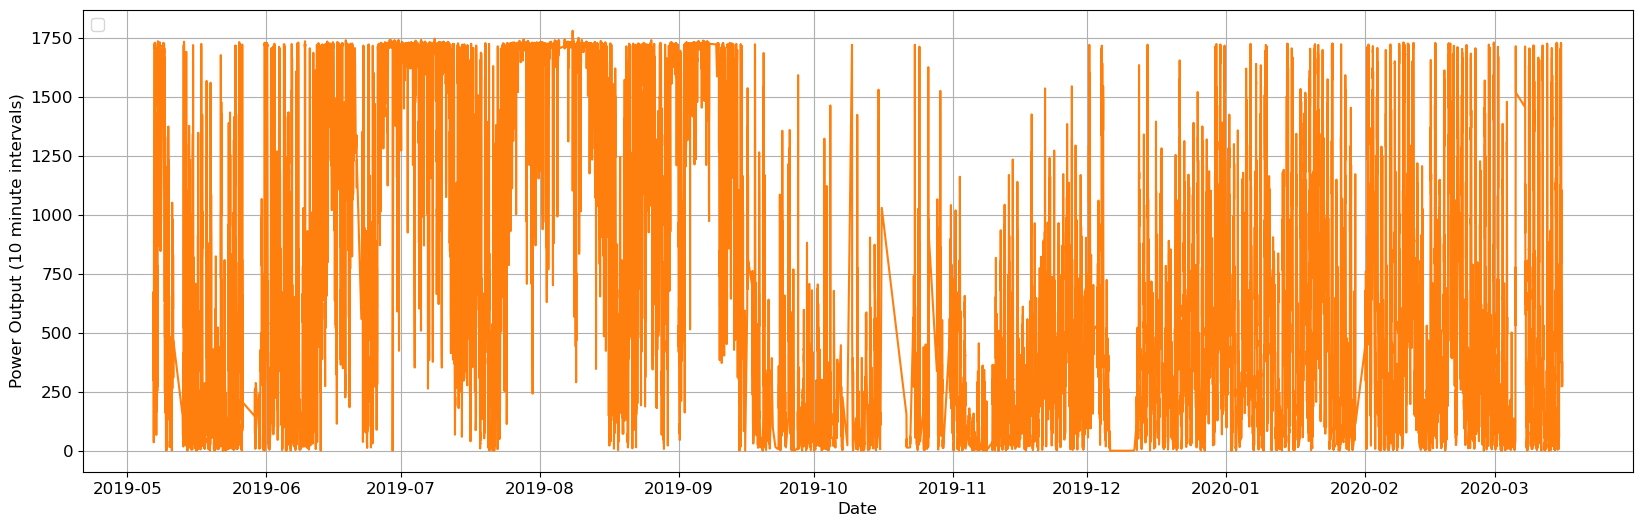

In [12]:
#time series plot
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(df.index, df.ActivePower, color='tab:orange')

ax.set_xlabel('Date')
ax.set_ylabel('Power Output (10 minute intervals)')
ax.grid(True)
ax.legend(loc='upper left');

In [13]:
features = [col for col in df.columns if col not in ['Active Power']]
target = 'ActivePower'

In [14]:
X = df[features]
y = df[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=False)

In [15]:
XGBRegressor._get_tags = lambda self: {}

model = XGBRegressor()

In [16]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

rs = RandomizedSearchCV(model, param_distributions=param_dist,
                        n_iter=20, scoring='neg_mean_squared_error',
                        cv=5, random_state=42, verbose=1)

rs.fit(X_train, y_train)

print("Best parameters found:", rs.best_params_)
best_cv_rmse = np.sqrt(-rs.best_score_)
print("Best CV RMSE:", best_cv_rmse)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best CV RMSE: 3.725126641938101


In [17]:
best_model = rs.best_estimator_
train_preds = best_model.predict(X_train)
val_preds = best_model.predict(X_val)
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_preds)))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, val_preds)))

Train RMSE: 1.987253355475752
Validation RMSE: 2.764762006899399


In [18]:
def create_features(df):
    df.sort_index(inplace=True)
    
    # Time features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    
    # Lag features
    df['lag_1'] = df['ActivePower'].shift(1)
    df['lag_hourly'] = df['ActivePower'].shift(6)
    df['lag_daily'] = df['ActivePower'].shift(24 * 6)
    df['lag_monthly'] = df['ActivePower'].shift(24 * 6 * 30)
    
    # Rolling statistics
    df['rolling_mean_7_days'] = df['lag_daily'].rolling(window=7*24*6).mean()
    df['rolling_mean_30_days'] = df['lag_daily'].rolling(window=30*24*6).mean()
    df['rolling_sd_7_days'] = df['lag_daily'].rolling(window=7*24*6).std()
    df['rolling_sd_30_days'] = df['lag_daily'].rolling(window=30*24*6).std()
    df['rolling_mean_24h'] = df['lag_hourly'].rolling(window=24*6).mean()
    df['rolling_sd_24h'] = df['lag_hourly'].rolling(window=24*6).std()
    
    return df

In [19]:
n_steps = n_steps = 15 * 24 * 6 # 15 days, 24 hours, 6 intervals per hour

forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(minutes=10), 
                             periods=n_steps, freq='10min')

history_df = df.copy()
predictions = []

for current_date in forecast_dates:
    new_row = pd.DataFrame(index=[current_date])
    # Time features
    new_row['hour'] = current_date.hour
    new_row['day_of_week'] = current_date.dayofweek
    new_row['month'] = current_date.month
    
    # Lag features
    new_row['lag_1'] = history_df['ActivePower'].iloc[-1]
    new_row['lag_hourly'] = history_df['ActivePower'].iloc[-6] if len(history_df) > 6 else history_df['ActivePower'].iloc[-1]
    new_row['lag_daily'] = history_df['ActivePower'].iloc[-144] if len(history_df) > 144 else history_df['ActivePower'].iloc[-1]
    new_row['lag_monthly'] = history_df['ActivePower'].iloc[-4320] if len(history_df) > 4320 else history_df['ActivePower'].iloc[-1]
    
    # Calculate rolling statistics using history_df
    new_row['rolling_mean_7_days'] = history_df['lag_daily'].iloc[-7*24*6:].mean()
    new_row['rolling_mean_30_days'] = history_df['lag_daily'].iloc[-30*24*6:].mean()
    new_row['rolling_sd_7_days'] = history_df['lag_daily'].iloc[-7*24*6:].std()
    new_row['rolling_sd_30_days'] = history_df['lag_daily'].iloc[-30*24*6:].std()
    new_row['rolling_mean_24h'] = history_df['lag_hourly'].iloc[-24*6:].mean()
    new_row['rolling_sd_24h'] = history_df['lag_hourly'].iloc[-24*6:].std()

    # Add any remaining features from the feature list
    turbine_features = [
        'AmbientTemperatue', 'BearingShaftTemperature',
        'Blade1PitchAngle', 'Blade2PitchAngle', 'Blade3PitchAngle',
        'GearboxBearingTemperature', 'GearboxOilTemperature', 'GeneratorRPM',
        'GeneratorWinding1Temperature', 'GeneratorWinding2Temperature',
        'HubTemperature', 'MainBoxTemperature', 'NacellePosition',
        'ReactivePower', 'RotorRPM', 'TurbineStatus', 'WindDirection',
        'WindSpeed'
    ]
    
    for feature in turbine_features:
        new_row[feature] = history_df[feature].iloc[-1]
    
    for col in features:
        if col not in new_row.columns:
            new_row[col] = history_df[col].iloc[-1]

    row_features = new_row[features].values.reshape(1, -1)
    prediction = best_model.predict(row_features)[0]
    
    new_row['ActivePower'] = prediction
    history_df = pd.concat([history_df, new_row])
    
    predictions.append({
        'Date': current_date,
        'Forecasting': prediction
    })

forecast_df = pd.DataFrame(predictions)

In [20]:
forecast_df

,Date,Forecasting
0,2020-03-16 00:00:00+00:00,374.329498
1,2020-03-16 00:10:00+00:00,374.192902
2,2020-03-16 00:20:00+00:00,374.182892
3,2020-03-16 00:30:00+00:00,374.198853
4,2020-03-16 00:40:00+00:00,374.207520
...,...,...
2155,2020-03-30 23:10:00+00:00,374.434875
2156,2020-03-30 23:20:00+00:00,374.434875
2157,2020-03-30 23:30:00+00:00,374.434875
2158,2020-03-30 23:40:00+00:00,374.434875


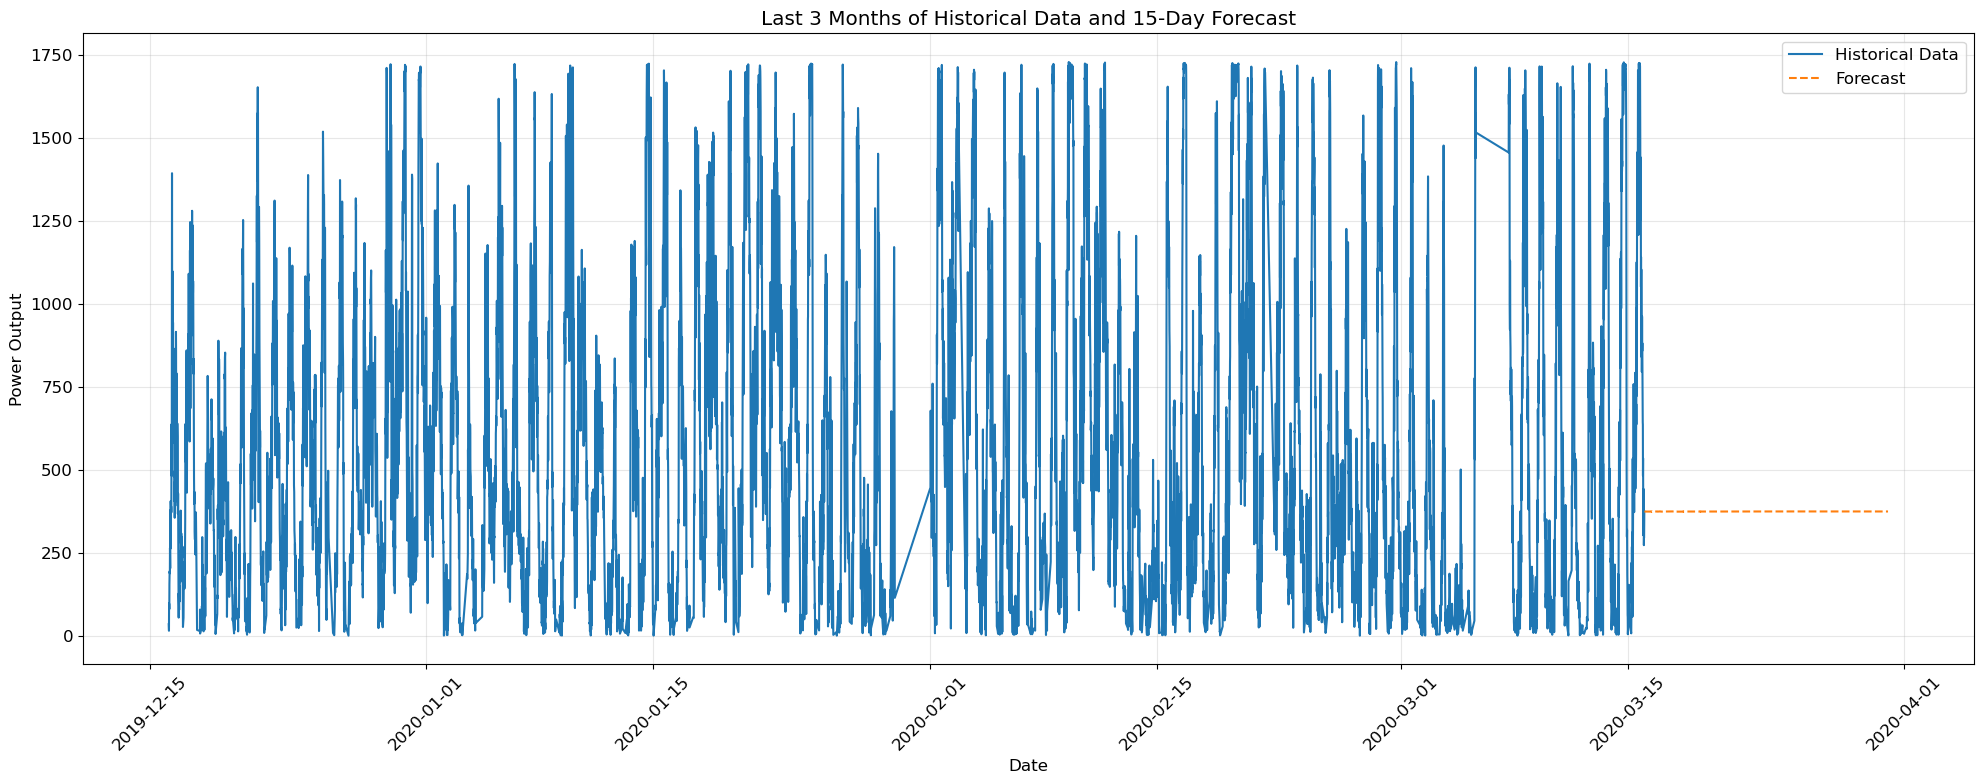

In [21]:
last_3_months = df.index[-1] - pd.DateOffset(months=3)

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 8))

historical_data = df[df.index >= last_3_months]
ax.plot(historical_data.index, historical_data.ActivePower, 
        label='Historical Data', color='tab:blue')

ax.plot(forecast_df['Date'], forecast_df['Forecasting'], 
        label='Forecast', color='tab:orange', linestyle='--')

ax.set_xlabel('Date')
ax.set_ylabel('Power Output')
ax.grid(True, alpha=0.3)
ax.legend()

plt.title('Last 3 Months of Historical Data and 15-Day Forecast')

plt.xticks(rotation=45)

plt.tight_layout()

# ARIMA

In [22]:
df = pd.read_csv("train_imputed.csv")
df = df[['Datetime', 'ActivePower']]
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Date'] = df['Datetime'].dt.date
df_daily = df[['Date', 'ActivePower']].groupby('Date').sum().reset_index().sort_values('Date')
df_daily

,Date,ActivePower
0,2018-01-01,24178.923956
1,2018-01-02,40070.788083
2,2018-01-03,40129.409441
3,2018-01-04,47287.251399
4,2018-01-05,30015.577400
...,...,...
728,2020-03-11,45696.346270
729,2020-03-12,51328.398473
730,2020-03-13,83651.039923
731,2020-03-14,97638.164507


In [23]:
# Convert to time series format
df_daily.set_index("Date", inplace=True)
ts_data = df_daily["ActivePower"]

# Define parameter grid
p_values = [0]
d_values = [0]
q_values = [0]
P_values = range(0, 1)
D_values = range(0, 1)
Q_values = range(0, 1)
s = 365  # Seasonal cycle (yearly seasonality)
validation_size = 15  # Validation set size in cross-validation
K_folds = 1

# Best model tracking
best_rmse, best_order, best_seasonal = float("inf"), None, None
results = []

# Grid Search
for order in itertools.product(p_values, d_values, q_values):
    for seasonal_order in itertools.product(P_values, D_values, Q_values):
        seasonal = (seasonal_order[0], seasonal_order[1], seasonal_order[2], s)
        rmse_total = 0

        # Rolling Cross-Validation (3-fold)
        train_size = len(ts_data) - K_folds * validation_size
        for k in range(K_folds):
            train = ts_data[: train_size + k * validation_size]
            test = ts_data[train_size + k * validation_size: train_size + k * validation_size + validation_size]

            try:
                model = SARIMAX(train, order=order, seasonal_order=seasonal, enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit(disp=False)
                predictions = model_fit.forecast(steps=len(test))
                rmse_total += np.sqrt(mean_squared_error(test, predictions))
            except:
                rmse_total += float("inf")

        avg_rmse = rmse_total / K_folds  # Average RMSE over folds
        results.append((order, seasonal, avg_rmse))

        # Keep track of the best model
        if avg_rmse < best_rmse:
            best_rmse, best_order, best_seasonal = avg_rmse, order, seasonal

        print(f"SARIMA{order} x {seasonal} RMSE={avg_rmse:.3f}")

# Print Best Model
print(f"\nBest SARIMA Model: ARIMA{best_order} x Seasonal{best_seasonal} with RMSE={best_rmse:.3f}")

SARIMA(0, 0, 0) x (0, 0, 0, 365) RMSE=63601.301

Best SARIMA Model: ARIMA(0, 0, 0) x Seasonal(0, 0, 0, 365) with RMSE=63601.301


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_pre